<a href="https://colab.research.google.com/github/rifqoi/Inacure-Machine-Learning/blob/main/03-ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset from Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [2]:
import re
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile

In [3]:
dataset_dir = f"/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

In [4]:
def list_images():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    validation_classes = os.listdir(os.path.join(validation_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    print(f"{folder}: \n \t{len(train_classes)} train images, {len(validation_classes)} validation images, and {len(test_classes)} test images,  total {len(train_classes) + len(validation_classes) + len(test_classes)} images")
    print()
list_images()

Kersen: 
 	81 train images, 23 validation images, and 13 test images,  total 117 images

Pepaya: 
 	168 train images, 47 validation images, and 25 test images,  total 240 images

Lengkuas: 
 	72 train images, 20 validation images, and 11 test images,  total 103 images

Jambu Biji: 
 	154 train images, 44 validation images, and 23 test images,  total 221 images

Jeruk Purut: 
 	135 train images, 38 validation images, and 21 test images,  total 194 images

Mint: 
 	302 train images, 85 validation images, and 45 test images,  total 432 images

Kelor: 
 	153 train images, 43 validation images, and 23 test images,  total 219 images

Lemon: 
 	151 train images, 42 validation images, and 23 test images,  total 216 images

Nangka: 
 	108 train images, 31 validation images, and 16 test images,  total 155 images

Bayam Hijau: 
 	206 train images, 58 validation images, and 31 test images,  total 295 images

Mangga: 
 	304 train images, 86 validation images, and 45 test images,  total 435 images



In [5]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                              rotation_range = 25,
                              zoom_range = [0.5, 1.1],
                              width_shift_range=0.15, 
                              shear_range= 0.15,
                              height_shift_range=0.15,
                              preprocessing_function=preprocess_input,
                              horizontal_flip=True,
                              vertical_flip= True,
                              fill_mode='nearest',)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      seed=42,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator(rescale = 1/255,
                                          preprocessing_function=preprocess_input)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                seed=42,
                                                                class_mode='sparse',
                                                                target_size=(224, 224))
  ### END CODE HERE
  test_datagen = ImageDataGenerator(rescale= 1./255.)

  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                shuffle=False, 
                                                                seed=42,
                                                                class_mode='sparse',
                                                                target_size=(224, 224))
  return train_generator, validation_generator, test_generator

In [6]:
train_generator, validation_generator, test_generator = train_val_generators(train_dir, validation_dir, test_dir)

Found 1876 images belonging to 12 classes.
Found 521 images belonging to 12 classes.
Found 275 images belonging to 12 classes.


In [62]:
class Model:
  def __init__(self, model, config):
    self.config = config
    self.batch_size = self.config['batch_size']
    # self.trainable = self.config['trainable']
    self.epochs = self.config['epochs']
    self.classes= self.config['classes']
    self.input_shape = self.config['input_shape']
    self.base_model = model

  def train_val_generators(self, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, preprocess_input=None):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                rotation_range = 25,
                                zoom_range = [0.5, 1.1],
                                width_shift_range=0.15, 
                                shear_range= 0.15,
                                height_shift_range=0.15,
                                preprocessing_function=preprocess_input,
                                horizontal_flip=True,
                                vertical_flip= True,
                                fill_mode='nearest',)
  
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32, 
                                                        seed=42,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  
    validation_datagen = ImageDataGenerator(rescale = 1/255,
                                            preprocessing_function=preprocess_input)
  
    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))
    ### END CODE HERE
    test_datagen = ImageDataGenerator(rescale= 1./255.)
  
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=32,
                                                                  shuffle=False, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))

    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.test_generator = test_generator
    return train_generator, validation_generator, test_generator

  def set_generator(self, train_generator, val_generator, test_generator, ):
    self.train_generator = train_generator
    self.valdation_generator = validation_generator
    self.test_generator = test_generator
  

  def build_model(self, compile_config):
    compile_config['metrics'] = [metric.replace("accuracy", "acc") for metric in compile_config['metrics']]

    # self.base_model.trainable = self.trainable
    flatten_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(512, activation='relu')
    prediction_layer = tf.keras.layers.Dense(self.classes, activation='softmax')
    self.model = tf.keras.models.Sequential([
                                             self.base_model,
                                             flatten_layer,
                                             dense_layer_1,
                                             prediction_layer])

    self.model.compile(**compile_config)
    self.model.summary()

    return self.model

  def train(self, model_name, reduce_lr_config=None):
    self.model_name = model_name
    model_filepath = model_name +'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks = [model_checkpoint, model_early_stopping]
    if reduce_lr_config is not None:
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_config)
      callbacks.append(reduce_lr)
    model_history = self.model.fit(self.train_generator, epochs = self.epochs,
                                   validation_data = self.validation_generator,callbacks=callbacks , verbose=1)
    self.history = model_history
    return model_history

  def plot_history(self):
    acc = self.history.history['acc']
    val_acc = self.history.history['val_acc']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.subplot()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
  
    plt.subplot()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.legend()
    plt.show()
    
    plt.show()

  def evaluate_model(self):
    evaluate = self.model.evaluate(self.test_generator)
    print('Loss of the model is - ', evaluate[0])
    print('Accuracy of the model is - ', evaluate[1]*100, '%')
  
    classes =  list(self.test_generator.class_indices.keys())
    Y_pred = self.model.predict(self.test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
    print('Confusion Matrix')
    conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues')
  
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
  
  def find_best_model(self, weights_dir):
    weights = os.listdir(weights_dir)
    weights = list(filter(lambda x: self.model_name in x, weights))

    best_acc = 0
    best_weight = None
    for weight in weights:
      acc = int(re.search(r"\.(\d+)\.", weight).group(1))
      if best_acc < acc:
        best_acc = acc
        best_weight = weight
    
    self.best_weight = os.path.join(weights_dir, best_weight)
    print(self.best_weight)

  def evaluate_best_model(self, ):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    self.evaluate_model()
  
  def save_best_model(self, target_dir):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    print(f"Copy {self.best_weight} to {target_dir}")
    shutil.copy(self.best_weight, target_dir)
  
  def load_best_model(self, weight_path):
    self.best_weight = weight_path
    self.model.load_weights(self.best_weight)

In [34]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 12,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": 'adam',
    "metrics": ["acc"],
}
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=config['input_shape'])
vgg16.trainable = False
vgg16_model = Model(model=vgg16, config=config)
vgg16_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg16_preprocess_input)
vgg16_model.build_model(compile_config)

Found 1876 images belonging to 12 classes.
Found 521 images belonging to 12 classes.
Found 275 images belonging to 12 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               12845568  
                                                                 
 dense_17 (Dense)            (None, 12)                6156      
                                                                 
Total params: 27,566,412
Trainable params: 12,851,724
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
vgg16_model.train(model_name='vgg16')

Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 2.6208 - acc: 0.4893 
Epoch 1: val_acc improved from -inf to 0.73129, saving model to vgg16-saved-model-01-acc-0.73.hdf5
59/59 [==============================] - 959s 16s/step - loss: 2.6208 - acc: 0.4893 - val_loss: 0.8684 - val_acc: 0.7313
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 0.8304 - acc: 0.7308
Epoch 2: val_acc improved from 0.73129 to 0.77351, saving model to vgg16-saved-model-02-acc-0.77.hdf5
59/59 [==============================] - 225s 4s/step - loss: 0.8304 - acc: 0.7308 - val_loss: 0.6914 - val_acc: 0.7735
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 0.7118 - acc: 0.7676
Epoch 3: val_acc improved from 0.77351 to 0.80806, saving model to vgg16-saved-model-03-acc-0.81.hdf5
59/59 [==============================] - 224s 4s/step - loss: 0.7118 - acc: 0.7676 - val_loss: 0.6167 - val_acc: 0.8081
Epoch 4/20
59/59 [==============================] - ETA: 0s - loss: 

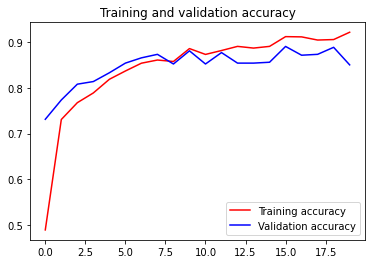

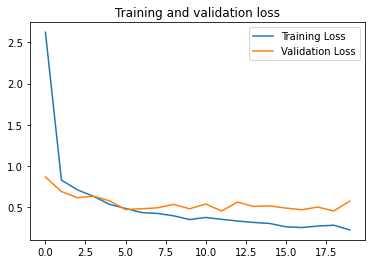

In [14]:
vgg16_model.plot_history()

1/9 [==>...........................] - ETA: 38s - loss: 0.0983 - acc: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 97s 12s/step - loss: 0.7911 - acc: 0.8291
Loss of the model is -  0.7911089062690735
Accuracy of the model is -  82.90908932685852 %
              precision    recall  f1-score   support

       Basil       1.00      1.00      1.00        16
 Bayam Hijau       0.64      0.97      0.77        29
  Jambu Biji       0.70      0.80      0.74        20
 Jeruk Purut       0.75      0.23      0.35        13
       Kelor       0.61      0.91      0.73        22
      Kersen       0.92      0.85      0.88        13
       Lemon       1.00      0.78      0.88        23
    Lengkuas       1.00      0.40      0.57        10
      Mangga       1.00      0.98      0.99        45
        Mint       0.88      0.80      0.84        45
      Nangka       0.87      0.87      0.87        15
      Pepaya       0.90      0.79      0.84        24

    accuracy                           0.83       275
   macro avg       0.85      0.78      0.79       275
weighted avg    

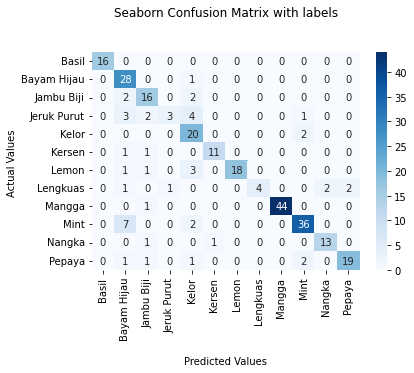

In [15]:
vgg16_model.evaluate_model()

In [35]:
vgg16_model.model_name = 'vgg16'
vgg16_model.find_best_model('.')

./vgg16-saved-model-16-acc-0.89.hdf5


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 29s 3s/step - loss: 0.6255 - acc: 0.8364
Loss of the model is -  0.6255186200141907
Accuracy of the model is -  83.63636136054993 %
              precision    recall  f1-score   support

       Basil       1.00      1.00      1.00        16
 Bayam Hijau       0.68      0.97      0.80        29
  Jambu Biji       0.79      0.75      0.77        20
 Jeruk Purut       0.67      0.46      0.55        13
       Kelor       0.76      0.73      0.74        22
      Kersen       0.91      0.77      0.83        13
       Lemon       1.00      0.65      0.79        23
    Lengkuas       1.00      0.50      0.67        10
      Mangga       1.00      0.98      0.99        45
        Mint       0.82      0.93      0.87        45
      Nangka       0.67      0.80      0.73        15
      Pepaya       0.84      0.88      0.86        24

    accuracy                           0.84       275
   macro avg       0.85      0.78      0.80       275
weighted avg     

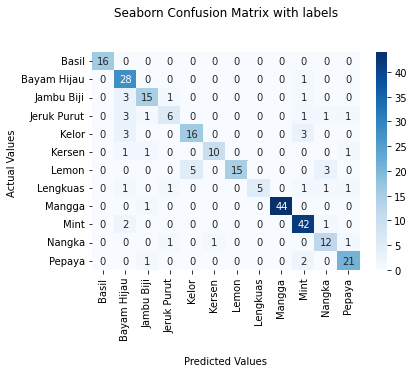

In [36]:
vgg16_model.evaluate_best_model()

In [72]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 12,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": 'adam',
    "metrics": ["accuracy"],
}

inceptionv3  = InceptionV3(weights="imagenet", include_top=False, input_shape=config['input_shape'], classes=config['classes'])
inceptionv3.trainable=False
# for layer in inceptionv3.layers[:249]:
#    layer.trainable = False
# for layer in inceptionv3.layers[249:]:
#    layer.trainable = True

iv3_model = Model(model=inceptionv3, config=config)
iv3_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=iv3_preprocess_input)
iv3_model.build_model(compile_config)

Found 1876 images belonging to 12 classes.
Found 521 images belonging to 12 classes.
Found 275 images belonging to 12 classes.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_11 (Flatten)        (None, 51200)             0         
                                                                 
 dense_22 (Dense)            (None, 512)               26214912  
                                                                 
 dense_23 (Dense)            (None, 12)                6156      
                                                                 
Total params: 48,023,852
Trainable params: 26,221,068
Non-trainable params: 21,802,784
_________________________________________________________________


In [73]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
iv3_model.train('inceptionv3', reduce_lr_config=reduce_lr_config)

Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 4.1195 - acc: 0.2846
Epoch 1: val_acc improved from -inf to 0.38964, saving model to inceptionv3-saved-model-01-acc-0.39.hdf5
59/59 [==============================] - 243s 4s/step - loss: 4.1195 - acc: 0.2846 - val_loss: 1.9879 - val_acc: 0.3896 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 1.6922 - acc: 0.4190
Epoch 2: val_acc improved from 0.38964 to 0.43378, saving model to inceptionv3-saved-model-02-acc-0.43.hdf5
59/59 [==============================] - 235s 4s/step - loss: 1.6922 - acc: 0.4190 - val_loss: 1.5874 - val_acc: 0.4338 - lr: 0.0010
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 1.5308 - acc: 0.4654
Epoch 3: val_acc improved from 0.43378 to 0.49712, saving model to inceptionv3-saved-model-03-acc-0.50.hdf5
59/59 [==============================] - 236s 4s/step - loss: 1.5308 - acc: 0.4654 - val_loss: 1.6836 - val_acc: 0.4971 - lr: 0.0010
Epoch 4/20
59

In [74]:
iv3_model.model_name = 'inceptionv3'
iv3_model.find_best_model('.')
iv3_model.evaluate_best_model()

./vgg16-saved-model-16-acc-0.89.hdf5


ValueError: ignored

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
iv3_model.save_best_model(target_dir=target_dir)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 12,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": 'adam',
    "metrics": ["accuracy"],
}
resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=config['input_shape'], classes=config['classes'])
resnet50_model = Model(model=resnet50, config=config)
resnet50_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=resnet50_preprocess_input)
resnet50_model.build_model(compile_config)

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
resnet50_model.train('resnet50', reduce_lr_config=reduce_lr_config)

In [ ]:
resnet50_model.model_name = 'resnet50'
resnet50_model.find_best_model('.')
resnet50_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
resnet50_model.save_best_model(target_dir=target_dir)

In [42]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [69]:
!wget https://media.discordapp.net/attachments/971451202267119678/977480585750667294/IMG20220521145825.jpg -O daun8.jpg

--2022-05-21 07:59:29--  https://media.discordapp.net/attachments/971451202267119678/977480585750667294/IMG20220521145825.jpg
Resolving media.discordapp.net (media.discordapp.net)... 162.159.128.232, 162.159.133.232, 162.159.134.232, ...
Connecting to media.discordapp.net (media.discordapp.net)|162.159.128.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2433187 (2.3M) [image/jpeg]
Saving to: ‘daun8.jpg’

daun8.jpg           100%[===================>]   2.32M  --.-KB/s    in 0.06s   

2022-05-21 07:59:30 (37.6 MB/s) - ‘daun8.jpg’ saved [2433187/2433187]



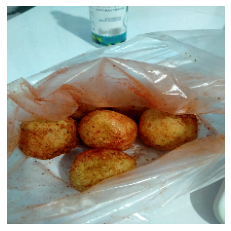

Bayam Hijau
Basil: 6.257737368287053e-05
Bayam Hijau: 83.37426781654358
Jambu Biji: 0.3123161615803838
Jeruk Purut: 0.09131033439189196
Kelor: 0.003601431308197789
Kersen: 0.01020308627630584
Lemon: 8.055337730183965e-06
Lengkuas: 0.08456410141661763
Mangga: 0.00046787704377493355
Mint: 15.751965343952179
Nangka: 0.12675788020715117
Pepaya: 0.24447834584861994


In [70]:
model = vgg16_model.model
label_map = (train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='daun8.jpg'
image = load_image(image_path, show=True)
predict = model.predict(image)
print(label_map[np.argmax(model.predict(image))])
predicted_list = [ele * 100 for ele in predict.flatten()]

for idx, ele in enumerate(predicted_list):
  print(f"{label_map[idx]}: {ele}")

In [ ]:
train_generator.class_indices

{'Basil': 0,
 'Bayam Hijau': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mangga': 8,
 'Mint': 9,
 'Nangka': 10,
 'Pepaya': 11}

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img =  cv2.imread('/istockphoto-584504750-1024x1024.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# find the green color 
mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
# find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
# find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

# find any of the three colors(green or brown or yellow) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= mask)

cv2_imshow(img)
cv2_imshow(res)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
train_generator.class_indices

{'Bayam Hijau': 0,
 'Jahe': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mint': 8,
 'Nangka': 9,
 'Pepaya': 10}